In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy.stats import multivariate_normal
from PIL import Image
from random import shuffle
from matplotlib.font_manager import FontProperties
from matplotlib.colors import ListedColormap
from itertools import combinations_with_replacement, combinations

### Sequential Bayesian Learning

**Connect to Google Drive to download dataset**

In [3]:
downloaded = drive.CreateFile({'id':"1hV6c4yRUQ5goHIwSpahHtpliOVH5HbJo"})
downloaded.GetContentFile('data.csv')
data = pd.read_csv('data.csv')

In [4]:
d = dict()
d['X'] = data['X'].values.reshape(100, 1)
d['T'] = data['T'].values.reshape(100, 1)

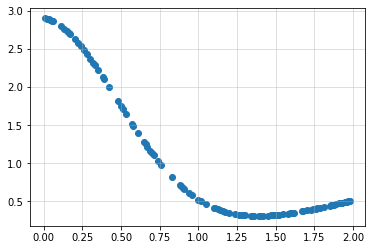

In [5]:
plt.scatter(d['X'], d['T'])
plt.grid(alpha = 0.5);

**Regression Model**

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_data_points(data, N):
    return data['X'][:N], data['T'][:N]

def Phi(x, M, s):
    phi = [[] for i in range(len(x))]
    for j in range(0, M):
        muj = 2 * j / M
        phi = np.concatenate((phi, sigmoid((x - muj) / s)), axis = 1)
    return phi

def posterior_distrib(x, t, M, s, alpha, beta):
    phi = Phi(x, M, s)
    SN = np.linalg.inv(alpha * np.eye(M) + beta * phi.T.dot(phi))
    mN = beta * SN.dot(phi.T).dot(t)
    return mN, SN

def predict_distrib(x, mN, SN, beta):
    phi = Phi(x, M, s)
    mean = phi.dot(mN)
    cov = 1 / beta + np.sum(phi.dot(SN).dot(phi.T), axis = 1)
    SD = np.sqrt(cov)
    return mean.reshape(len(x)), SD

**Experiment Settings**

In [7]:
M = 3
s = 0.6
alpha = math.pow(10, -6)
beta = 1
N_list = [5, 10, 30, 50, 80]

In [8]:
def pdf(x, mu, sigma):
    return (1 / np.sqrt((2 * np.pi) ** 2 * np.linalg.det(sigma))) * \
        np.exp(-((x - mu).T @ np.linalg.inv(sigma) @ (x - mu)) / 2)

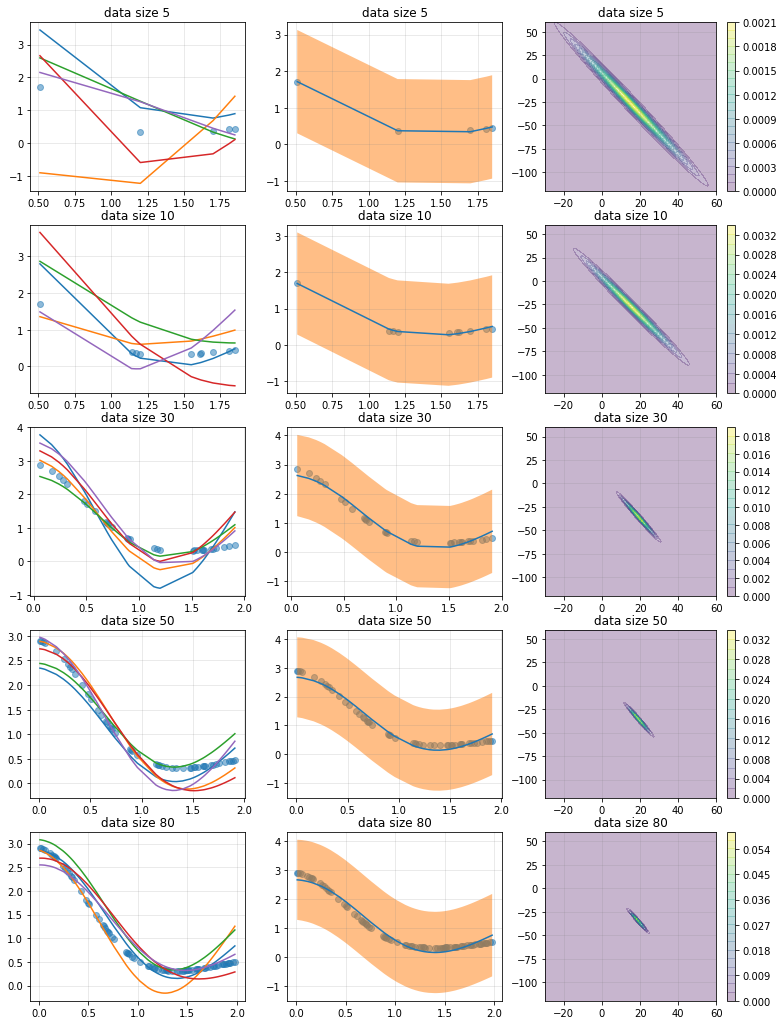

In [9]:
fig, axes = plt.subplots(5, 3, figsize=(15, 18))

for i in range(len(N_list)):
    N = N_list[i]
    x, t = get_data_points(d, N)

    mN, SN = posterior_distrib(x, t, M, s, alpha, beta)
    w = multivariate_normal(mean = mN.reshape(M), cov = SN).rvs(size = 5)

    axes[i, 0].scatter(x, t, alpha = 0.5)
    axes[i, 1].scatter(x, t, alpha = 0.5)

    x = np.array(sorted(x))

    for _w in w:
        y = _w.dot(Phi(x, M, s).T)
        axes[i, 0].plot(x, y, '-')
    axes[i, 0].grid(alpha = 0.2, color = "gray")

    mean, SD = predict_distrib(x, mN, SN, beta)
    axes[i, 1].fill_between(x.reshape(len(x)), mean - SD, mean + SD, alpha = 0.5)
    axes[i, 1].plot(x, mean)
    axes[i, 1].grid(alpha = 0.2, color = "gray")
    
    mu = mN[0:2]
    sigma = SN[0:2, 0:2]
    x = np.linspace(-30, 60, 100)
    y = np.linspace(-120, 60, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((100, 100))
    for a in range(100):
        for b in range(100):
            Z[a,b] = pdf(np.matrix([[X[a,b]], [Y[a,b]]]), mu, sigma)
    cfig = axes[i, 2].contourf(X, Y, Z, 20, alpha = 0.3)
    axes[i, 2].grid(alpha = 0.2, color = "gray")
    fig.subplots_adjust(right = 0.8)
    fig.colorbar(cfig, ax = axes[i, 2])

    for j in range(3):
      axes[i, j].set_title('data size %d' % N)

### Logistic Regression

**Connect to Google Drive to download dataset**

In [10]:
downloaded = drive.CreateFile({'id':"1mFxMI-PP0UW3gvqXq_-gA3hMN19FUp55"})
downloaded.GetContentFile('Fashion_MNIST.zip')

**Unzip Dataset**

In [11]:
!unzip Fashion_MNIST.zip

Archive:  Fashion_MNIST.zip
replace Fashion_MNIST/0/2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Show Image Format**

In [12]:
image = Image.open('/content/Fashion_MNIST/0/0.png')
print(image.format)
print(image.size)
print(image.mode)

PNG
(28, 28)
L


**Dataloader**

In [13]:
def dataLoader():
    # Random order
    order = [x for x in range(0, 64)]
    shuffle(order)
    
    train_x = []
    train_t = []
    test_x = []
    test_t = []

    for i in range(0, 5):
        for j in order[:32]:
            tmp = np.asarray(Image.open('/content/Fashion_MNIST/{}/{}.png'.format(i, j)))
            tmp = tmp.tolist()
            train_x.append(tmp)
            train_t.append([i])
        for k in order[32:]:
            tmp = np.asarray(Image.open('/content/Fashion_MNIST/{}/{}.png'.format(i, k)))
            tmp = tmp.tolist()
            test_x.append(tmp)
            test_t.append([i])
    return train_x, train_t, test_x, test_t

In [14]:
train_x, train_t, test_x, test_t = dataLoader()

**Preprocess**

In [15]:
# Normalize the pixels in data
train_x = np.array(train_x).reshape(160, -1) / 255
test_x = np.array(test_x).reshape(160, -1) / 255

In [16]:
def oneHotEncoding(x):
    return np.array(pd.get_dummies(pd.Series(x.reshape(-1))))

In [17]:
# Preprocess the dummy variable
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
train_t = oneHotEncoding(np.array(train_t).reshape(160, -1))
test_t = oneHotEncoding(np.array(test_t).reshape(160, -1))

**Logistic Regression Model**

In [18]:
def softmax(ak):
    return np.exp(ak) / np.exp(ak).sum(axis = 1)[:, None]

In [19]:
def LogisticRegression(train_x, train_t, lr, epoch, method = 'GD'):
    # Create bias term
    if method == 'GD':
        bias = np.ones_like(train_x[:,0]).reshape(len(train_x), -1)
        train_x = np.concatenate((bias, train_x), axis = 1)

    # Training
    w = np.zeros((train_x.shape[1], 5))
    Entropy_train = []
    Accuracy_train = []
    Weight_train = []

    if method == 'GD':
        for i in range(epoch):
            ak = train_x.dot(w)
            y = softmax(ak)
            E_grad = train_x.T.dot(y - train_t)
            w = w - lr * E_grad

            y_class = np.argmax(y, axis=1)
            t_class = np.argmax(train_t, axis=1)
            acc = np.count_nonzero((y_class - t_class) == 0) / y_class.shape[0]

            Entropy_train.append(-1 * np.multiply(np.log2(y), train_t).sum())
            Accuracy_train.append(acc)
            Weight_train.append(w)
    elif method == 'NR':
        for i in range(epoch):    
            ak = train_x.dot(w)
            y = softmax(ak)
            R = np.diag(np.array([y[i].dot((1 - y[i])) for i in range(160)]))
            w = w - np.linalg.inv(train_x.T @ R @ train_x) @ train_x.T @ (y - train_t)

            y_class = np.argmax(y, axis=1)
            t_class = np.argmax(train_t, axis=1)
            acc = np.count_nonzero((y_class - t_class) == 0) / y_class.shape[0]

            Entropy_train.append(-1 * np.multiply(np.log2(y), train_t).sum())
            Accuracy_train.append(acc)
            Weight_train.append(w)
            
    return w, Entropy_train, Accuracy_train, Weight_train

**Training**

In [20]:
w, Entropy_train, Accuracy_train, Weight_train = LogisticRegression(train_x, train_t, lr = 0.001, epoch = 50, method = 'GD')

In [21]:
def Predict(w, test_x, epoch, Weight_train, method = 'GD'):
    if method == 'GD':
        bias = np.ones_like(test_x[:,0]).reshape(len(test_x), -1)
        test_x = np.concatenate((bias, test_x), axis = 1)

    Entropy_test = []
    Accuracy_test = []
    for i in range(epoch):
        ak = test_x.dot(Weight_train[i])
        y = softmax(ak)

        y_class = np.argmax(y, axis=1)
        t_class = np.argmax(test_t, axis=1)
        acc = np.count_nonzero((y_class-t_class) == 0) / y_class.shape[0]
        Entropy_test.append(-1 * np.multiply(np.log2(y), test_t).sum())
        Accuracy_test.append(acc)

    return softmax(test_x.dot(w)), Entropy_test, Accuracy_test

**Testing**

In [22]:
y, Entropy_test, Accuracy_test = Predict(w, test_x, 50, Weight_train, method = 'GD')

**Plot**

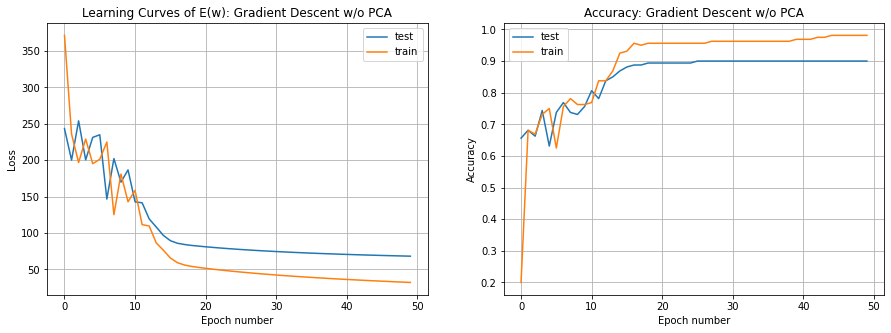

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title("Learning Curves of E(w): Gradient Descent w/o PCA")
ax[0].set_xlabel("Epoch number")
ax[0].set_ylabel("Loss")
ax[0].grid(True)
ax[0].plot(Entropy_test, label = "test")
ax[0].plot(Entropy_train, label = "train")
ax[0].legend()

ax[1].set_title("Accuracy: Gradient Descent w/o PCA")
ax[1].set_xlabel("Epoch number")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)
ax[1].plot(Accuracy_test, label = "test")
ax[1].plot(Accuracy_train, label = "train")
ax[1].legend()

plt.show()

**Classification results**

In [24]:
print("TYPE: Gradient Descent w/o PCA")
print("Training Accuracy:", Accuracy_train[-1])
print("Test Accuracy:", Accuracy_test[-1])

TYPE: Gradient Descent w/o PCA
Training Accuracy: 0.98125
Test Accuracy: 0.9


#### PCA

**Mean Face**

In [25]:
w, h = 784, 160;
mean_face = [0 for i in range(w)] 

for i in range(h):
    for j in range(w):
        mean_face[j] += train_x[i][j]

for i in range(h):
    mean_face[j] /= 160

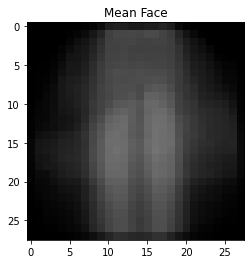

In [26]:
mean_face_n = np.array(mean_face) / 255
mean_face_f = np.array(mean_face_n).reshape(28, -1)

img = Image.fromarray(mean_face_f * 255)
plt.title('Mean Face')
plt.imshow(img)

**Sub Face**

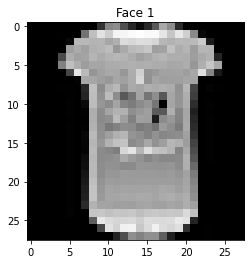

In [27]:
face = np.array(train_x[0]).reshape(28, -1)
img = Image.fromarray(face * 255)
plt.title('Face 1')
plt.imshow(img)

In [28]:
for i in range(160):
    train_x[i] = train_x[i] - mean_face_n

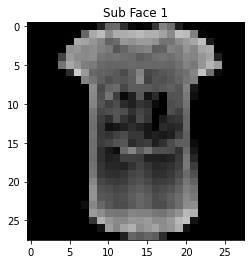

In [29]:
sub_face = np.array(train_x[0]).reshape(28, -1)
img = Image.fromarray(sub_face * 255)
plt.title('Sub Face 1')
plt.imshow(img)

In [30]:
covariance_train = np.cov(train_x.T)
eig_val_train, eig_vec_train = np.linalg.eig(covariance_train)

In [31]:
variance_explained = []
for i in eig_val_train:
     variance_explained.append((i/sum(eig_val_train))*100)
        
print(variance_explained)

[(32.474440499112305+0j), (17.793063061276705+0j), (6.599000398734245+0j), (5.006153449645754+0j), (4.230869019166461+0j), (2.567303058577725+0j), (2.0289496111447347+0j), (1.725508326565198+0j), (1.5476900623624557+0j), (1.3164312182693179+0j), (1.240270285073946+0j), (1.1109750613491054+0j), (0.9859496600510159+0j), (0.9312049242908855+0j), (0.833137670336718+0j), (0.8068677323232487+0j), (0.672497226598183+0j), (0.6235729795078168+0j), (0.5762259960386704+0j), (0.5387000568609613+0j), (0.5315714727368293+0j), (0.5299839290815119+0j), (0.49569849269953603+0j), (0.4853880643070462+0j), (0.43598371837738936+0j), (0.4537305150519288+0j), (0.4026252516347386+0j), (0.3880711928430238+0j), (0.3736623132111686+0j), (0.365904977916618+0j), (0.35557644748213196+0j), (0.3335146914407195+0j), (0.3275225643196038+0j), (0.30968105639050375+0j), (0.30748477080816417+0j), (0.2920094249622534+0j), (0.28070663627214065+0j), (0.26982839190409114+0j), (0.26556653780896794+0j), (0.26125532314771466+0j),

In [32]:
def PCA(x, n, eig_vec, eig_val):
    eig_pairs = [(np.abs(eig_val[i]), eig_vec[:, i]) for i in range(len(eig_val))]
    eig_pairs.sort(key = lambda x: x[0], reverse = True)
    w = np.array([eig_pairs[i][1] for i in range(n)], dtype = 'float32')
    return x.dot(w.T)

**Reduce the dimension of images to d**

In [33]:
pca_train_2 = PCA(train_x, 2, eig_vec_train, eig_val_train)
pca_train_5 = PCA(train_x, 5, eig_vec_train, eig_val_train)
pca_train_10 = PCA(train_x, 10, eig_vec_train, eig_val_train)

pca_test_2 = PCA(test_x, 2, eig_vec_train, eig_val_train)
pca_test_5 = PCA(test_x, 5, eig_vec_train, eig_val_train)
pca_test_10 = PCA(test_x, 10, eig_vec_train, eig_val_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


**Training**

In [34]:
w_2_NR, Entropy_train_2_NR, Accuracy_train_2_NR, Weight_train_2_NR = LogisticRegression(pca_train_2, train_t, lr = 0.001, epoch = 50, method = 'NR')
w_5_NR, Entropy_train_5_NR, Accuracy_train_5_NR, Weight_train_5_NR = LogisticRegression(pca_train_5, train_t, lr = 0.001, epoch = 50, method = 'NR')
w_10_NR, Entropy_train_10_NR, Accuracy_train_10_NR, Weight_train_10_NR = LogisticRegression(pca_train_10, train_t, lr = 0.001, epoch = 50, method = 'NR')

**Testing**

In [35]:
y_2_NR, Entropy_test_2_NR, Accuracy_test_2_NR = Predict(w_2_NR, pca_test_2, 50, Weight_train_2_NR, method = 'NR')
y_5_NR, Entropy_test_5_NR, Accuracy_test_5_NR = Predict(w_5_NR, pca_test_5, 50, Weight_train_5_NR, method = 'NR')
y_10_NR, Entropy_test_10_NR, Accuracy_test_10_NR = Predict(w_10_NR, pca_test_10, 50, Weight_train_10_NR, method = 'NR')

**Plot**

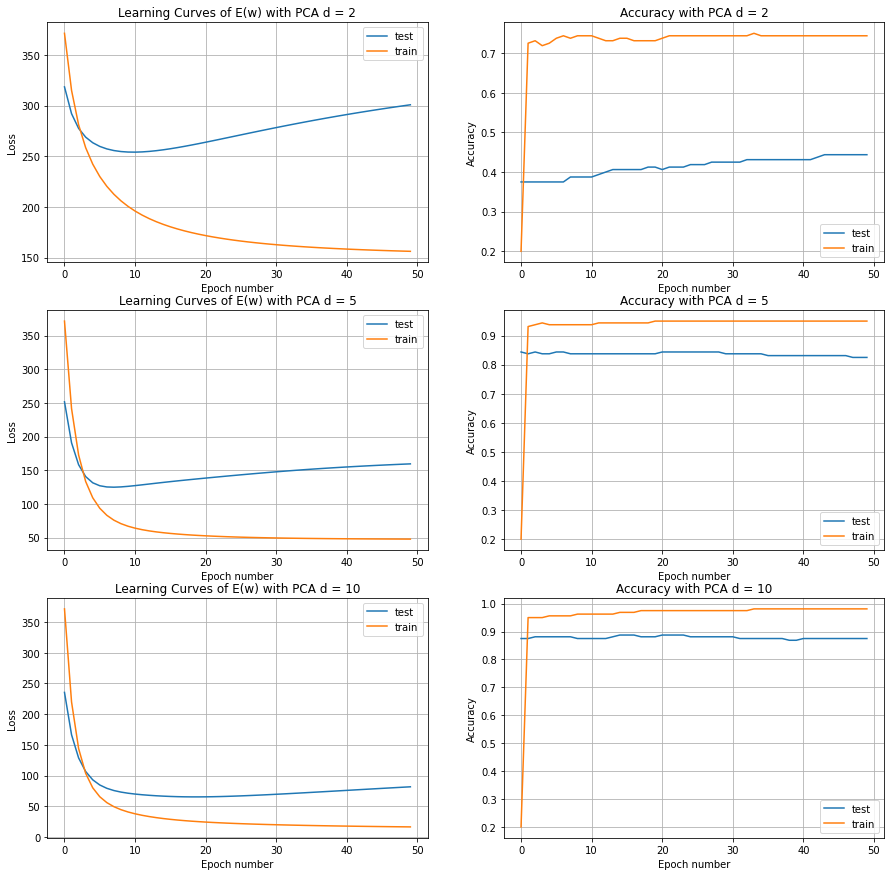

In [36]:
N_list = [2, 5, 10]

fig, ax = plt.subplots(3, 2, figsize=(15, 15))

ax[0][0].set_title("Learning Curves of E(w) with PCA d = 2")
ax[0][0].set_xlabel("Epoch number")
ax[0][0].set_ylabel("Loss")
ax[0][0].grid(True)
ax[0][0].plot(Entropy_test_2_NR, label = "test")
ax[0][0].plot(Entropy_train_2_NR, label = "train")
ax[0][0].legend()

ax[0][1].set_title("Accuracy with PCA d = 2")
ax[0][1].set_xlabel("Epoch number")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].grid(True)
ax[0][1].plot(Accuracy_test_2_NR, label = "test")
ax[0][1].plot(Accuracy_train_2_NR, label = "train")
ax[0][1].legend()

ax[1][0].set_title("Learning Curves of E(w) with PCA d = 5")
ax[1][0].set_xlabel("Epoch number")
ax[1][0].set_ylabel("Loss")
ax[1][0].grid(True)
ax[1][0].plot(Entropy_test_5_NR, label = "test")
ax[1][0].plot(Entropy_train_5_NR, label = "train")
ax[1][0].legend()

ax[1][1].set_title("Accuracy with PCA d = 5")
ax[1][1].set_xlabel("Epoch number")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].grid(True)
ax[1][1].plot(Accuracy_test_5_NR, label = "test")
ax[1][1].plot(Accuracy_train_5_NR, label = "train")
ax[1][1].legend()

ax[2][0].set_title("Learning Curves of E(w) with PCA d = 10")
ax[2][0].set_xlabel("Epoch number")
ax[2][0].set_ylabel("Loss")
ax[2][0].grid(True)
ax[2][0].plot(Entropy_test_10_NR, label = "test")
ax[2][0].plot(Entropy_train_10_NR, label = "train")
ax[2][0].legend()

ax[2][1].set_title("Accuracy with PCA d = 10")
ax[2][1].set_xlabel("Epoch number")
ax[2][1].set_ylabel("Accuracy")
ax[2][1].grid(True)
ax[2][1].plot(Accuracy_test_10_NR, label = "test")
ax[2][1].plot(Accuracy_train_10_NR, label = "train")
ax[2][1].legend()
plt.show()

**Classification results**

In [37]:
print("TYPE: Newton-Raphson algorithms with PCA d = 2")
print("Training Accuracy:", Accuracy_train_2_NR[-1])
print("Test Accuracy:", Accuracy_test_2_NR[-1])

print("TYPE: Newton-Raphson algorithms with PCA d = 5")
print("Training Accuracy:", Accuracy_train_5_NR[-1])
print("Test Accuracy:", Accuracy_test_5_NR[-1])

print("TYPE: Newton-Raphson algorithms with PCA d = 10")
print("Training Accuracy:", Accuracy_train_10_NR[-1])
print("Test Accuracy:", Accuracy_test_10_NR[-1])

TYPE: Newton-Raphson algorithms with PCA d = 2
Training Accuracy: 0.74375
Test Accuracy: 0.44375
TYPE: Newton-Raphson algorithms with PCA d = 5
Training Accuracy: 0.95
Test Accuracy: 0.825
TYPE: Newton-Raphson algorithms with PCA d = 10
Training Accuracy: 0.98125
Test Accuracy: 0.875


**Plot Eigenvectors**

In [38]:
eig_pairs = [(np.abs(eig_val_train[i]), eig_vec_train[:, i]) for i in range(len(eig_val_train))]
eig_pairs.sort(key = lambda x: x[0], reverse = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


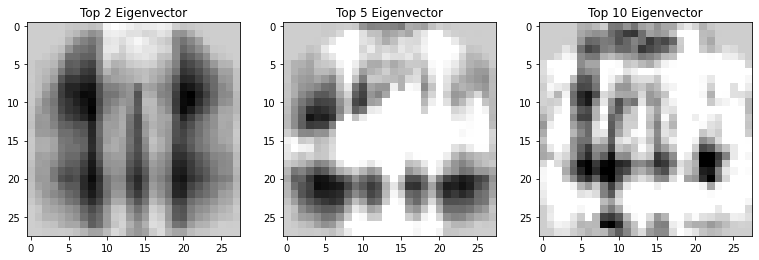

In [39]:
N_list = [2, 5, 10]

fig, ax = plt.subplots(1, 3, figsize=(13, 5))

for i in range(len(N_list)):
    projection_matrix = eig_pairs[N_list[i] - 1][1]
    projection_matrix = np.array(projection_matrix.real)

    max, min = eig_pairs[1][1].max(), eig_pairs[1][1].min()
    for j in range(784):
        projection_matrix[j] = (projection_matrix[j] - min) / (max - min)
    
    projection_matrix = np.array(projection_matrix.real).reshape(28, -1)
    img = Image.fromarray(projection_matrix * 255)
    ax[i].set_title('Top %d Eigenvector' % N_list[i])
    ax[i].imshow(img)
    projection_matrix.fill(0)

plt.show()

#### Decision Regions

In [40]:
def get_hot_value(my_list):
    max_val = 0
    one_hot = []
    position = []

    for i in range(len(my_list)):
        if my_list[i] > max_val:
            max_val = my_list[i]

    for i in range(len(my_list)):
        if my_list[i] == max_val:
            position.append(i)
    
    for i in range(len(my_list)):
        one_hot.append(int(position[0] == i)) 

    return one_hot

In [41]:
# ground truth
train_t_dummy = [np.where(r == 1)[0][0] for r in train_t]

**Plot M = 1**

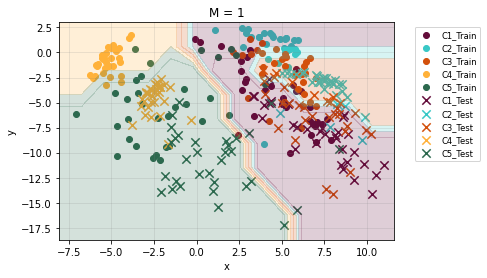

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
color = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139', '#2C694E']

# Plot data points
ax.scatter(   pca_train_2[:32,0],    pca_train_2[:32,1],   c = color[train_t_dummy[0]], label = 'C1_Train')
ax.scatter( pca_train_2[32:64,0],  pca_train_2[32:64,1],  c = color[train_t_dummy[32]], label = 'C2_Train')
ax.scatter( pca_train_2[64:96,0],  pca_train_2[64:96,1],  c = color[train_t_dummy[64]], label = 'C3_Train')
ax.scatter(pca_train_2[96:128,0], pca_train_2[96:128,1],  c = color[train_t_dummy[96]], label = 'C4_Train')
ax.scatter(  pca_train_2[128:,0],   pca_train_2[128:,1], c = color[train_t_dummy[128]], label = 'C5_Train')

ax.scatter(   pca_test_2[:32,0],     pca_test_2[:32,1],   c = color[train_t_dummy[0]],  label = 'C1_Test', marker = 'x', s = 70)
ax.scatter( pca_test_2[32:64,0],   pca_test_2[32:64,1],  c = color[train_t_dummy[32]],  label = 'C2_Test', marker = 'x', s = 70)
ax.scatter( pca_test_2[64:96,0],   pca_test_2[64:96,1],  c = color[train_t_dummy[64]],  label = 'C3_Test', marker = 'x', s = 70)
ax.scatter(pca_test_2[96:128,0],  pca_test_2[96:128,1],  c = color[train_t_dummy[96]],  label = 'C4_Test', marker = 'x', s = 70)
ax.scatter(  pca_test_2[128:,0],    pca_test_2[128:,1], c = color[train_t_dummy[128]],  label = 'C5_Test', marker = 'x', s = 70)

# Set font size
fontP = FontProperties()
fontP.set_size('small')

# Plot decision regions
x_min, x_max = pca_train_2[:, 0].min() - 1, pca_train_2[:, 0].max() + 5
y_min, y_max = pca_train_2[:, 1].min() - 8, pca_train_2[:, 1].max() + 3
h1 = (x_max - x_min) / 16
h2 = (y_max - y_min) / 10
X, Y = np.meshgrid(np.arange(x_min, x_max, h1), np.arange(y_min, y_max, h2))

Z, Entropy_grid, Accuracy_grid = Predict(w_2_NR, np.c_[X.ravel(), Y.ravel()], 50, Weight_train_2_NR, method = 'NR')
Z_oh = np.array([get_hot_value(sublist) for sublist in Z])
Z_dummy = np.array([np.where(r == 1)[0][0] for r in Z_oh])
Z_dummy = Z_dummy.reshape(X.shape)

cmap = ListedColormap(color[:len(np.unique(Z_dummy))])
cfig = ax.contourf(X, Y, Z_dummy, cmap = cmap, alpha = 0.2)

ax.grid(alpha = 0.2, color = "gray")
ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', prop = fontP)
ax.set_title('M = 1')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.show()

**Plot M = 2**

In [43]:
def applyPolynomialOrder(x, m):
    N = len(x[0])

    l = np.full((len(x), 1), 1)

    for order in range(1, m + 1):
        for combination in list(combinations_with_replacement(range(N), order)):
            tmp = x[:, combination]
            p = np.expand_dims(np.prod(tmp, axis=1), axis=1)
            l = np.concatenate((l, p), axis=1)
    return l

In [44]:
pca_train_2_M2 = applyPolynomialOrder(pca_train_2, 2)

In [45]:
w_2_NR_M2, Entropy_train_2_NR_M2, Accuracy_train_2_NR_M2, Weight_train_2_NR_M2 = LogisticRegression(pca_train_2_M2, train_t, lr = 0.001, epoch = 50, method = 'NR')

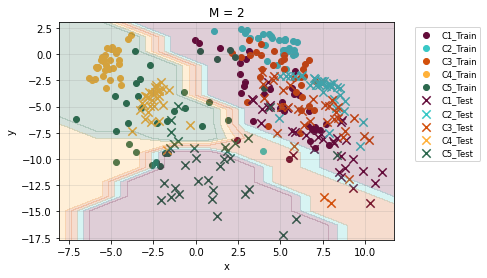

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
color = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139', '#2C694E']

# Plot data points
ax.scatter(   pca_train_2[:32,0],    pca_train_2[:32,1],   c = color[train_t_dummy[0]], label = 'C1_Train')
ax.scatter( pca_train_2[32:64,0],  pca_train_2[32:64,1],  c = color[train_t_dummy[32]], label = 'C2_Train')
ax.scatter( pca_train_2[64:96,0],  pca_train_2[64:96,1],  c = color[train_t_dummy[64]], label = 'C3_Train')
ax.scatter(pca_train_2[96:128,0], pca_train_2[96:128,1],  c = color[train_t_dummy[96]], label = 'C4_Train')
ax.scatter(  pca_train_2[128:,0],   pca_train_2[128:,1], c = color[train_t_dummy[128]], label = 'C5_Train')

ax.scatter(   pca_test_2[:32,0],     pca_test_2[:32,1],   c = color[train_t_dummy[0]],  label = 'C1_Test', marker = 'x', s = 70)
ax.scatter( pca_test_2[32:64,0],   pca_test_2[32:64,1],  c = color[train_t_dummy[32]],  label = 'C2_Test', marker = 'x', s = 70)
ax.scatter( pca_test_2[64:96,0],   pca_test_2[64:96,1],  c = color[train_t_dummy[64]],  label = 'C3_Test', marker = 'x', s = 70)
ax.scatter(pca_test_2[96:128,0],  pca_test_2[96:128,1],  c = color[train_t_dummy[96]],  label = 'C4_Test', marker = 'x', s = 70)
ax.scatter(  pca_test_2[128:,0],    pca_test_2[128:,1], c = color[train_t_dummy[128]],  label = 'C5_Test', marker = 'x', s = 70)

# Set font size
fontP = FontProperties()
fontP.set_size('small')

# Plot decision regions
x_min, x_max = pca_train_2_M2[:, 0].min() - 1, pca_train_2_M2[:, 0].max() + 1   # bias
y_min, y_max = pca_train_2_M2[:, 1].min() - 1, pca_train_2_M2[:, 1].max() + 6   # a
h1 = (x_max - x_min) / 16
h2 = (y_max - y_min) / 10
X, Y = np.meshgrid(np.arange(x_min, x_max, h1), np.arange(y_min, y_max, h2))

a_min, a_max = pca_train_2_M2[:, 2].min() - 7, pca_train_2_M2[:, 2].max() + 2   # b
b_min, b_max = pca_train_2_M2[:, 3].min() - 1, pca_train_2_M2[:, 3].max() + 1  
h3 = (a_max - a_min) / 16
h4 = (b_max - b_min) / 10
A, B = np.meshgrid(np.arange(a_min, a_max, h3), np.arange(b_min, b_max, h4))

c_min, c_max = pca_train_2_M2[:, 4].min() - 1, pca_train_2_M2[:, 4].max() + 1
d_min, d_max = pca_train_2_M2[:, 5].min() - 1, pca_train_2_M2[:, 5].max() + 1
h5 = (c_max - c_min) / 16
h6 = (d_max - d_min) / 10
C, D = np.meshgrid(np.arange(c_min, c_max, h5), np.arange(d_min, d_max, h6))

Z, Entropy_grid, Accuracy_grid = Predict(w_2_NR_M2, np.c_[X.ravel(), Y.ravel(), A.ravel(), B.ravel(), C.ravel(), D.ravel()], 50, Weight_train_2_NR_M2, method = 'NR')
Z_oh = np.array([get_hot_value(sublist) for sublist in Z])
Z_dummy = np.array([np.where(r == 1)[0][0] for r in Z_oh])
Z_dummy = Z_dummy.reshape(X.shape)

cmap = ListedColormap(color[:len(np.unique(Z_dummy))])
cfig = ax.contourf(Y, A, Z_dummy, cmap = cmap, alpha = 0.2)

ax.grid(alpha = 0.2, color = "gray")
ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', prop = fontP)
ax.set_title('M = 2')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.show()